# Task 2

## Overview

Using the transformed data from the first task, write a script in PySpark or an equivalent language, that determines for each player the most “intense” 5 minute segment of the match.  Additionally, calculate a metric called “spread” which is the distance between all players on the field at any moment in time and find the 2 minute segment with the highest spread. How do these two metrics relate to each other?

## 5-minute "Intense" Segment

The definition of intense according Merriam Webster is "existing in an extreme degree; : exhibiting strong feeling or earnestness of purpose". I choose to interpret this as hitting the top average speed in 5-minute window for each player, with and without possession of the ball. Since speed is distance over time, and the time is constant here, which means calculating the distance covered within 5-minute window should be sufficient.
For simplicity purpose, the 5-minute segment starts at minute mark, e.g. 00:01:00 or 01:33:00. The 5-minute segment window does not stretch across halftime.
There are caveats with my method of defining intensity. For instance, goalkeepers should be judged differently than outfield players. Running around the penalty box might not automatically translate as the most intensive moment for a keeper. There is also the question about intensity with ball vs intensity without ball.

The steps I take to answer "Intense" questions are:
1. Query __Player__, __Frame__, and __Track__ table/parquet file to get all the players, frames, periods, timestamps, and x-y coordinates in the match.
2. Calculate the euclidean distance travelled/covered between adjacent frame for each player.
3. Sum the total distance travelled for 5-minute segment per minut per each player.
4. Output the mapping of player and his/her most intense 5-minute segment.

### 1. Dataset Query

In [1]:
game_id = 10000  # Convert to argument if the code is written in Python module

In [2]:
import sqlite3

con = sqlite3.connect('srcftbl.db')

In [3]:
import datetime
import logging
import math
import os

import pandas as pd
import pyspark.pandas as ps


logger = logging.getLogger('py4j')
logger.setLevel(logging.ERROR)

import pyspark.pandas as ps

ps.set_option('compute.ops_on_diff_frames', True)

/home/reyadji/.pyenv/versions/3.10.12/lib/python3.10/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(
23/12/10 21:14:55 WARN Utils: Your hostname, ALDO-DESKTOP resolves to a loopback address: 127.0.1.1; using 172.19.19.57 instead (on interface eth0)
23/12/10 21:14:55 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/10 21:14:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Get all the players from a game

In [4]:
game_player_df = pd.read_sql(f"SELECT * FROM player WHERE game_id = {game_id}", con=con)

In [5]:
len(game_player_df)

36

In [6]:
len(game_player_df.loc[~game_player_df['start_time'].isna()])

26

36 players from both teams, including starters and substitutes; 26 players played.

In [7]:
trackable_objects_list = game_player_df.loc[~game_player_df['start_time'].isna()]['trackable_object'].tolist()

Get all the frames from the game

In [8]:
frame_df = ps.read_parquet("frame.parquet")
game_frames_df = frame_df[frame_df['game_id'] == game_id][['game_id', 'frame', 'period', 'timestamp_in_seconds']]

/home/reyadji/.pyenv/versions/3.10.12/lib/python3.10/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_parquet`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Get all the tracking data from the game

In [9]:
track_df = ps.read_parquet("track.parquet")
game_tracks_df = track_df.loc[
    (track_df['game_id']==game_id) 
    & (track_df['trackable_object'].isin(trackable_objects_list))
]

/home/reyadji/.pyenv/versions/3.10.12/lib/python3.10/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_parquet`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


#### Combine both frames and tracking dataframe

In [10]:
game_df = game_tracks_df.merge(game_frames_df, how="inner", on=["game_id", "frame"])
game_df['trackable_object'] = game_df['trackable_object'].astype(int)

### 2. Calculate the distance travel for between adjacent frame for each player

In [11]:
game_df.set_index(["trackable_object"], inplace=True)  # Set trackable_object as index for easier grouping

In [12]:
# Internal functions

def calculate_diff(df):
    df['delta_x'] = df['x'].diff()  # Calculate x diff. between adjacent frame
    df = df.sort_index()
    df['delta_y'] = df['y'].diff() # Calculate y diff. between adjacent frame
    df = df.sort_index()
    return df
    
def calculate_distance(delta_x, delta_y):
    return math.sqrt(delta_x**2 + delta_y**2)

def find_max_intense(df):
    return iterate_dataframe(df, 5, 'eucl_dist')

def iterate_dataframe(df, segment, col):
    output_dict = {} # mapping of (start segment, end segment, which half): total distance
    one_minute = 60
    window = segment * one_minute
    
    for p in range(1, 3):
        if p == 1:
            i = 0     # start of 1st half
        else:
            i = 2700  # start of 2nd half
    
        half_df = df.loc[df['period'] == p]
        end_of_half = half_df['timestamp_in_seconds'].max()
        while i < end_of_half:
            output_dict[i/one_minute, (i+window)/one_minute, p] = \
                half_df.loc[half_df['timestamp_in_seconds'].between(i, i+window, inclusive='left')][col].sum()
            i += one_minute # shift segment to the next minute
    # return output_dict
    return max(output_dict, key=output_dict.get)  # return the top segment

### 3. Sum the total distance travelled for 5-minute segment per minute per each player.

In [13]:
player_5min_intense = {}  # trackable object: 5 minute window

# Iterate for each player in the metadata player list
start_time = datetime.datetime.now()
for player in trackable_objects_list:
    df = game_df.loc[player].set_index('frame')

    df = calculate_diff(df)
    
    # Necessary conversion to pandas dataframe from PySpark dataframe for applying custom function to multiple columns
    pdf = df.to_pandas()

    pdf['eucl_dist'] = pdf.apply(lambda x: calculate_distance(x.delta_x, x.delta_y), axis=1)

    player_5min_intense[player] = find_max_intense(pdf)

run_time = datetime.datetime.now() - start_time

print(f"Run time: {run_time}")

/home/reyadji/.pyenv/versions/3.10.12/lib/python3.10/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
23/12/10 21:15:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 21:15:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 21:15:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 21:15:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 21:15:13 WAR

Run time: 0:01:13.239677


### 4. Output the mapping of player and his/her most intense 5-minute segment.

In [14]:
player_5min_intense

{18731: (76.0, 81.0, 2),
 18848: (69.0, 74.0, 2),
 11879: (86.0, 91.0, 2),
 2776: (43.0, 48.0, 1),
 4683: (87.0, 92.0, 2),
 12140: (28.0, 33.0, 1),
 13254: (69.0, 74.0, 2),
 13195: (45.0, 50.0, 2),
 18724: (77.0, 82.0, 2),
 3108: (45.0, 50.0, 2),
 11723: (43.0, 48.0, 1),
 1790: (83.0, 88.0, 2),
 18763: (45.0, 50.0, 2),
 14237: (45.0, 50.0, 2),
 18726: (43.0, 48.0, 1),
 12315: (29.0, 34.0, 1),
 11847: (45.0, 50.0, 2),
 9449: (76.0, 81.0, 2),
 7745: (83.0, 88.0, 2),
 5318: (43.0, 48.0, 1),
 11537: (77.0, 82.0, 2),
 3847: (77.0, 82.0, 2),
 3267: (15.0, 20.0, 1),
 11565: (45.0, 50.0, 2),
 851: (35.0, 40.0, 1),
 9143: (28.0, 33.0, 1)}

## 2-minute "Spread" Segment

Instead of calculating the distance between all players, which is sigma notation of 22, for each frame, I choose to calculate the centroid of all players for each frame and calculate the distance of each player to the centroid for the "spread". The 2-minute segment is the average of "spread" for each frame in the 2 minute window. 
The alternative to this method is to simply calculate __Variance__ or __Standard Deviation__ of the all trackable_objects for each frame. This is easier to implement, but harder to explain in regard of the original definition of "Spread".

### 1. Calculate the centroid for each frame 

I am reusing the original base dataframe from Part 1

In [11]:
centroid_df = game_df.groupby(['frame', 'period', 'timestamp_in_seconds']).agg(
    centroid_x = pd.NamedAgg('x','avg'),
    centroid_y = pd.NamedAgg('y','avg'),
).reset_index()

Merge the centroid dataframe to the original dataframe

In [12]:
game_df = game_df.merge(centroid_df, how="outer", on=["frame", "period", "timestamp_in_seconds"], left_index=False, right_index=True)

### 2. Calculate distance of each players to the centroid for each frame

In [13]:
def calculate_distance(delta_x: ps.Series, delta_y: ps.Series) -> ps.Series:
    result = math.sqrt(delta_x**2 + delta_y**2)
    return result

def calculate_distance_to_centroid(df: ps.DataFrame) -> ps.Series:
    delta_x = df['x'] - df['centroid_x']
    delta_y = df['y'] - df['centroid_y']
    return calculate_distance(delta_x, delta_y)

In [14]:
game_df['dist_to_centroid'] = game_df.apply(lambda x: calculate_distance_to_centroid(x), axis=1)

/home/reyadji/.pyenv/versions/3.10.12/lib/python3.10/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If the type hints is not specified for `apply`, it is expensive to infer the data type internally.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


### 3. Sum the distance to the centroid per each frame

In [15]:
spread_df = game_df.groupby(['frame', 'period', 'timestamp_in_seconds'])['dist_to_centroid'].sum().reset_index()

/home/reyadji/.pyenv/versions/3.10.12/lib/python3.10/site-packages/pyspark/pandas/groupby.py:893: FutureWarning: Default value of `numeric_only` will be changed to `False` instead of `True` in 4.0.0.
  warnings.warn(


In [16]:
spread_df = spread_df.to_pandas()

/home/reyadji/.pyenv/versions/3.10.12/lib/python3.10/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/home/reyadji/.pyenv/versions/3.10.12/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py:224: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/reyadji/.pyenv/versions/3.10.12/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py:224: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/reyadji/.pyenv/versions/3.10.12/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.

### 4. Find the highest spread

In [25]:
def find_highest_spread(df):
    start_time = datetime.datetime.now()
    result = iterate_dataframe(df, 2, 'dist_to_centroid')
    duration = datetime.datetime.now() - start_time
    print(f"Run time: {duration}")
    return result

In [34]:
spread_output = find_highest_spread(spread_df)

print(f"The highest Spread happen at {spread_output}")

Run time: 0:00:00.039499
The highest Spread happen at (43.0, 45.0, 1)


## Relation between "Intense" and "Spread"

This is the list of players peak 5-minute segment intensity from above.

In [15]:
player_5min_intense

{18731: (76.0, 81.0, 2),
 18848: (69.0, 74.0, 2),
 11879: (86.0, 91.0, 2),
 2776: (43.0, 48.0, 1),
 4683: (87.0, 92.0, 2),
 12140: (28.0, 33.0, 1),
 13254: (69.0, 74.0, 2),
 13195: (45.0, 50.0, 2),
 18724: (77.0, 82.0, 2),
 3108: (45.0, 50.0, 2),
 11723: (43.0, 48.0, 1),
 1790: (83.0, 88.0, 2),
 18763: (45.0, 50.0, 2),
 14237: (45.0, 50.0, 2),
 18726: (43.0, 48.0, 1),
 12315: (29.0, 34.0, 1),
 11847: (45.0, 50.0, 2),
 9449: (76.0, 81.0, 2),
 7745: (83.0, 88.0, 2),
 5318: (43.0, 48.0, 1),
 11537: (77.0, 82.0, 2),
 3847: (77.0, 82.0, 2),
 3267: (15.0, 20.0, 1),
 11565: (45.0, 50.0, 2),
 851: (35.0, 40.0, 1),
 9143: (28.0, 33.0, 1)}

Create a histogram plot for each minute of the game based on the list of tuple above

In [14]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')

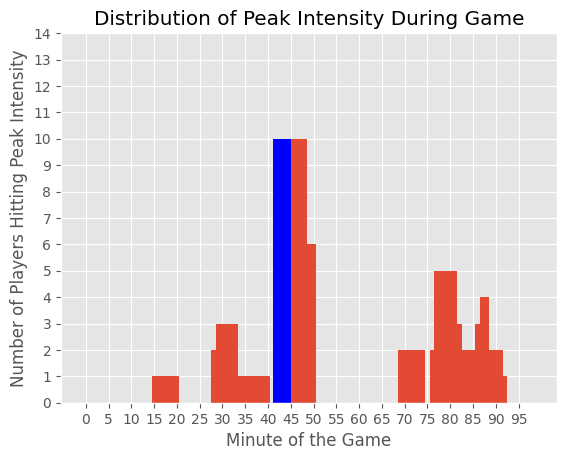

In [70]:
# Create a list of all points between the start and end of the 5-minute window
points = [list(range(int(start), int(end+1))) for start, end, _ in player_5min_intense.values()]
points = [item for row in points for item in row]
bins = range(min(points), max(points) + 2)

# Create histogram
plt.hist(points, bins=range(0, 100), align='left')
plt.bar(43, height=10, width=4, color='blue')
plt.xticks(np.arange(0, 100, 5))
plt.yticks(np.arange(0, 15, 1))
plt.xlabel('Minute of the Game')
plt.ylabel('Number of Players Hitting Peak Intensity')
plt.title('Distribution of Peak Intensity During Game')

plt.show()

Based from the plot above, the most "Intense" 5-minute segment for this game (45th - 48th minute) closely follows the highest 2-minute "Spread" (43rd - 45th minute). This makes some sense considering I am using total distance covered for both metrics. I cannot fully explain how they do not fully overlap, but this correlation is something that can be verified with different game datasets.